**1. Fetch dataset**

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

The MNIST dataset contains 70,000 small images of handwritten digits.

In [ ]:
print(type(mnist))
mnist.keys()

<class 'sklearn.utils.Bunch'>


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html - More information about Bunch data type

**2. Explore dataset**

In [ ]:
X = mnist['data']
y = mnist['target']

print('Data shape:', X.shape)
print('Target shape:', y.shape)

print(X)

Data shape: (70000, 784)
Target shape: (70000,)
       pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
0         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
1         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
2         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
3         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
4         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
69995     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
69996     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
69997     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
69998     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
69999     0.0     0.0     0.0     0.0  

28x28 = 784. The data is an array of the pixel values (between 0 and 255).

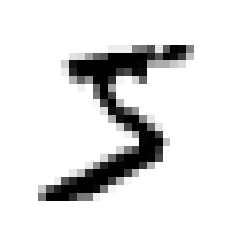

Target: 5


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

print('Target:', y[0])

**3. Prepare for classifier**

In [ ]:
# Convert targets to ints for ML algorithms
y = y.astype(np.uint8)

In [ ]:
# Create training and test set
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

Dataset set is already shuffled. Select first 60,000 for training and remaining for testing.

**4. Trying binary classifiers**

In [ ]:
# Prepare for binary classification
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print(y_test_5)

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) # Relies on randomness during training, for reproducible results set the parameter
sgd_clf.fit(X_train, y_train_5) # Train on whole training set

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit]) # Predict hand drawn 5 from earlier

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

**5. Implementing cross-validation**

At each iteration: create clone of classifier, train the clone on the training folds, and make prediction on test fold.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


*Update from book: use iloc.*

.iloc helps us select a particular cell of a DataFrame

https://www.askpython.com/python/built-in-methods/python-iloc-function - more info

**6. Using scikitlearn's cross validation**

In [ ]:
from sklearn.model_selection import cross_val_score

# 3-fold cross validation
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

**7. Confusion matrix**

In [ ]:
from sklearn.model_selection import cross_val_predict

# Performs cros-validation, but instead of returning evaluation scores, it returns the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

TN = 53,892

FP = 687

FN = 1891

TP = 3530

**8. Investigating the precision/recall trade-off**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:', precision_score(y_train_5, y_train_pred))
print('Recall:', recall_score(y_train_5, y_train_pred))
print('F1 score:', f1_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score: 0.7325171197343846


In [ ]:
# Return the decision scores of all the instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

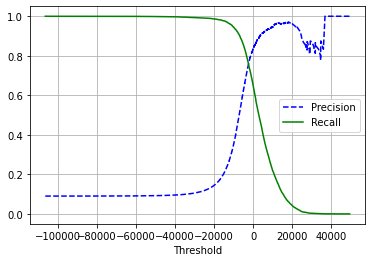

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.xlabel('Threshold')
  plt.grid()
  plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

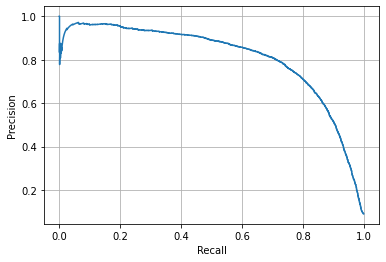

In [ ]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

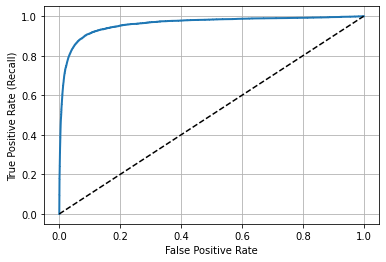

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
  plt.grid()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (Recall)')
  plt.show()

plot_roc_curve(fpr, tpr)
plt.show()

Trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays far away from that line as possible (toward the top-left corner).

We can compute the area under the curve (AUC).
Good classifier will have area equal to 1.
Purely random classifier will have area equal to 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score

# Compute the ROC (AUC)
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**9. Trying other classifiers**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf =  RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

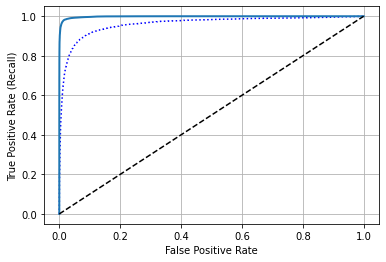

In [ ]:
# roc_curve() function expects labels and scores. 
# Instead of scores we can give probabilities.
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

As shown by the graph, the RandomForestClassifer works better than the SGD classifier. The RandomForestClassifier has a bigger ROC AUC as it is further in the top left corner than the SGD.

**10. Multiclass classification**

In [ ]:
# Multiclass classification with a SVM

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train.values, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit-Learn automatically detects it is a multi-class classification task. It performs the OvO (one v one) stratgey, training 45 binary classifiers.

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

10 scores returned per instance - one score per class representing the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores

In [ ]:
# Forcing the strategy: OvO or OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.values, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# Multiclass classification with a SGDClassifier
sgd_clf.fit(X_train.values, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

10 scores returned in total this time. Classifier used a OvR strategy unde the hood. The classifier predicted wrong.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

85%+ accuracy on all test folds. Random guessing would get around 10%. We can improve this by scaling the inputs.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

**11. Error analysis**

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

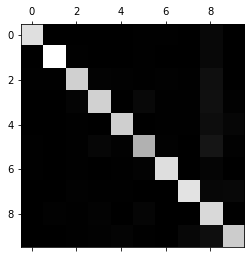

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()